## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [9]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [10]:
train, test = keras.datasets.cifar10.load_data()

In [11]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y   

In [12]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [13]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [14]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [15]:
import tensorflow as tf
import keras.backend as K

def combined_loss(gamma=2., alpha=4., ce_weights=0.7, fcl_weights=0.3):
    gamma = float(gamma)
    alpha = float(alpha)
    def CE_focal_loss(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        
        ce_loss = keras.losses.categorical_crossentropy(y_true, y_pred)
        return (ce_weights*ce_loss) + (fcl_weights*tf.reduce_mean(reduced_fl) )
    return CE_focal_loss

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [16]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss=combined_loss(ce_weights=ce_w, fcl_weights=1.-ce_w), 
                  metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, ce_weight: 0.00


W0731 16:40:20.192889 12408 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0731 16:40:20.205854 12408 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
__________

W0731 16:40:20.596095 12408 deprecation.py:323] From C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 15s 301us/step - loss: 6.0073 - acc: 0.3336 - val_loss: 6.7585 - val_acc: 0.3109
Epoch 2/25
50000/50000 [==============================] - 4s 80us/step - loss: 4.3353 - acc: 0.4494 - val_loss: 5.0866 - val_acc: 0.3828
Epoch 3/25
50000/50000 [==============================] - 4s 79us/step - loss: 3.9251 - acc: 0.4898 - val_loss: 4.4338 - val_acc: 0.4264
Epoch 4/25
50000/50000 [==============================] - 4s 79us/step - loss: 3.6537 - acc: 0.5165 - val_loss: 4.3446 - val_acc: 0.4327
Epoch 5/25
50000/50000 [==============================] - 4s 84us/step - loss: 3.4344 - acc: 0.5359 - val_loss: 4.1542 - val_acc: 0.4578
Epoch 6/25
50000/50000 [==============================] - 4s 81us/step - loss: 3.2370 - acc: 0.5600 - val_loss: 4.0707 - val_acc: 0.4611
Epoch 7/25
50000/50000 [==============================] - 4s 82us/step - loss: 3.0666 - acc: 0.5742 - val_loss: 3.9910 - val_a

50000/50000 [==============================] - 4s 80us/step - loss: 1.0981 - acc: 0.7894 - val_loss: 3.5834 - val_acc: 0.4845
Epoch 25/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.0303 - acc: 0.8014 - val_loss: 3.5502 - val_acc: 0.4886
Numbers of exp: 2, ce_weight: 0.50
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_11 (Batc (None, 256) 

50000/50000 [==============================] - 4s 81us/step - loss: 1.6614 - acc: 0.6083 - val_loss: 2.2503 - val_acc: 0.4789
Epoch 13/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.6080 - acc: 0.6197 - val_loss: 2.2258 - val_acc: 0.4886
Epoch 14/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.5551 - acc: 0.6307 - val_loss: 2.2390 - val_acc: 0.4840
Epoch 15/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.5068 - acc: 0.6405 - val_loss: 2.2113 - val_acc: 0.4906
Epoch 16/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.4628 - acc: 0.6506 - val_loss: 2.2153 - val_acc: 0.4911
Epoch 17/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.4099 - acc: 0.6638 - val_loss: 2.2138 - val_acc: 0.4919
Epoch 18/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.3612 - acc: 0.6736 - val_loss: 2.2475 - val_acc: 0.4907
Epoch 19/25
50000/50000 [=====================

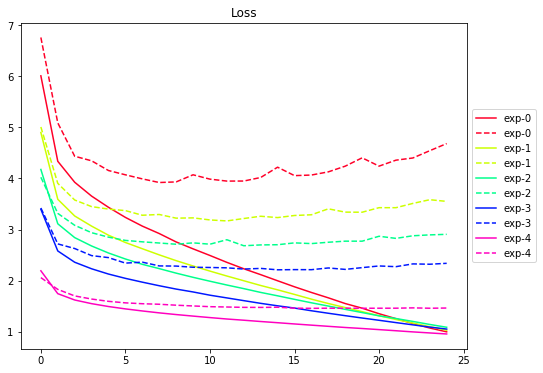

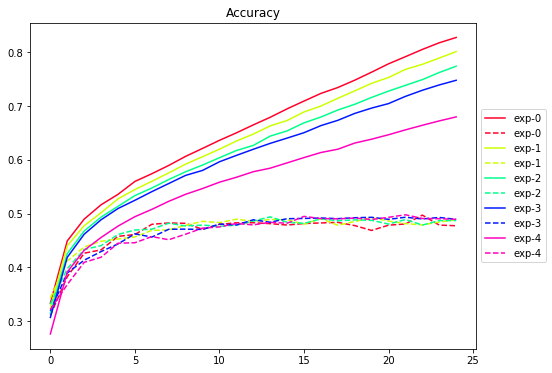

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()